In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [3]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_cost` function below:

In [4]:
def compute_loss_MSE(y, tx, w):

    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute loss by MSE
    # ***************************************************
    
    return np.sum((y - tx @ w) ** 2) / (2 * y.shape[0]);

In [5]:
def compute_loss_MAE(y, tx, w):

    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute loss by MSE
    # ***************************************************
    
    return np.sum(np.abs(y - tx @ w)) / y.shape[0];

#### Exercise 1
+ Each column of $\tilde{X}$ represents a feature.
+ Each row of $\tilde{X}$ represents a datum.
+ The 1s in $\tilde{X}$ add a bias term into matrix math.
+ The shape of $y$ would be $3 \times 1$, the shape of $\tilde{X}$ would be $3 \times 3$. Therefore, $\tilde{X}_{32}$ would represent the height of the third person.
+ The helper function `load_data` uses `np.genfromtxt` to load csv data.
+ The sizes make sense. 
#### Proofs.

1. Let $e=y-\tilde{X}w$ be a column vector of errors. Call its $n$'th component $e_n=y_n - \tilde{x}_n w$, where $\tilde{x}_n$ is the $n$'th row of $\tilde{X}$, $w$ is a column vector of weights, and $y_n$ is the $n$'th component of $y$. Then $\mathcal{L}(w)=\frac{1}{2N}\sum_{n=1}^{N}(y_n - \tilde{x}_n w)^2=\frac{1}{2N}\sum_{n=1}^{N}e_n^2=\frac{1}{2N}e^Te$.
2. (Below)

In [6]:
print("Mean absolute error:\t", compute_loss_MAE(y, tx, [1, 2]))
print("Mean squared error:\t", compute_loss_MSE(y, tx, [1, 2]))

Mean absolute error:	 72.29392200210518
Mean squared error:	 2694.4833658870843


# 2. Grid Search

Fill in the function `grid_search()` below:

In [8]:
# from costs import *

def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.
        
    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute loss for each combination of w0 and w1.
    # ***************************************************
    for i, w0 in enumerate(grid_w0):
        for j, w1 in enumerate(grid_w1):
            losses[i, j] = compute_loss_MSE(y, tx, np.array([w0, w1]))
    
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=18.793541019523236, w0*=71.42857142857142, w1*=15.306122448979579, execution time=0.271 seconds


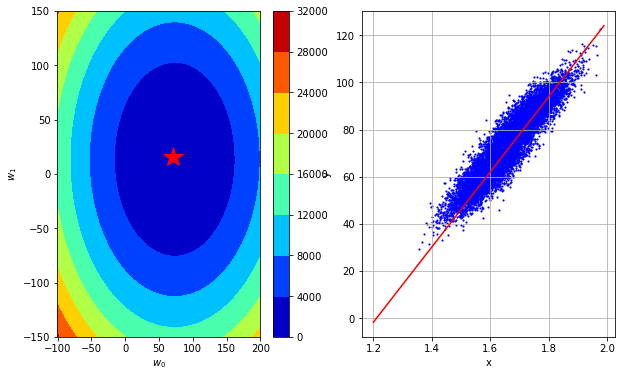

In [9]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=50)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

#### Exercise 2
+ This estimate looks slightly off. The resolution of the grid search is not large enough to get close to the optimal $(w_0^*, w_1^*)$
+ The MSE plot is not smooth because it is interpolated from a low resolution grid search.
+ The fit is much better for 2500 weight pairs sampled.
+ You are more likely to find an accurate fit with a fine grid, but the search is more costly. Furthermore, a course grid could by perfect chance hit the minimum while a slightly finer one does not
+ The computational cost increases as a square of the number of intervals.

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [375]:
def compute_gradient_MSE(y, tx, w):
    """Computes the gradient at w.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.
        
    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute gradient vector
    # ***************************************************
    N = y.shape[0]
    e = y - tx @ w
    gradient = - (e @ tx) / N
    
    return gradient

#### Exercise 3
+ Test $y=[1,2,3]^T$, $\tilde{X}=\begin{bmatrix}1 & 2\\ 1 & 2\\ 1 & 2\end{bmatrix}$, $w=[1, 2]^T$ yields $\nabla\mathcal{L}(w)=[3,6]^T$

In [376]:
m_y = np.array([1, 2, 3])
m_tx = np.array([[1, 2], [1, 2], [1, 2]])
m_w = np.array([1, 2])
compute_gradient_MSE(m_y, m_tx, m_w)

array([3., 6.])

+ Compute gradients for $w_0=100, w_1=20$ and $w_0=50, w_1=10$

In [377]:
print(compute_gradient_MSE(y, tx, [100, 20]))
print(compute_gradient_MSE(y, tx, [50, 10]))

[26.706078    6.52028757]
[-23.293922    -3.47971243]


+ The gradients point in the direction of steepest ascent. If the norm is larger, then we are generally further away from the minimum given that the function is convex.

Please fill in the functions `gradient_descent` below:

In [378]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD 
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        
        g = compute_gradient_MSE(y, tx, w)
        loss = compute_loss_MSE(y, tx, w)
        w = w - gamma * g
        
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [379]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 1

# Initialization
w_initial = np.array([-100, 100])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=18773.6576694708, w0=73.2939220021056, w1=13.479712434988727
GD iter. 1/49: loss=15.3858878688294, w0=73.29392200210519, w1=13.479712434989048
GD iter. 2/49: loss=15.3858878688294, w0=73.29392200210519, w1=13.479712434989048
GD iter. 3/49: loss=15.3858878688294, w0=73.29392200210519, w1=13.479712434989048
GD iter. 4/49: loss=15.3858878688294, w0=73.29392200210519, w1=13.479712434989048
GD iter. 5/49: loss=15.3858878688294, w0=73.29392200210519, w1=13.479712434989048
GD iter. 6/49: loss=15.3858878688294, w0=73.29392200210519, w1=13.479712434989048
GD iter. 7/49: loss=15.3858878688294, w0=73.29392200210519, w1=13.479712434989048
GD iter. 8/49: loss=15.3858878688294, w0=73.29392200210519, w1=13.479712434989048
GD iter. 9/49: loss=15.3858878688294, w0=73.29392200210519, w1=13.479712434989048
GD iter. 10/49: loss=15.3858878688294, w0=73.29392200210519, w1=13.479712434989048
GD iter. 11/49: loss=15.3858878688294, w0=73.29392200210519, w1=13.479712434989048
GD iter. 12/49:

+ When $\gamma = 0.001$, convergence is very slow. When $\gamma = 1$, convergence is instant, so it doesn't matter what values you put for `w_initial`. 

In [380]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses, gd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4. Stochastic gradient descent

In [381]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from just few examples n and their corresponding y_n labels.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.
        
    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """
    N = y.shape
    e = y - tx @ w
    return - (e @ tx) / N


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).
            
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD 
    """
    
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    for n_iter in range(max_iters):
        loss = compute_loss_MSE(y, tx, w)
        
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
            g = compute_stoch_gradient(minibatch_y, minibatch_tx, w)
            w = w - gamma * g

        
        print("SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

In [382]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=2792.2367127591674, w0=5.128640039746891, w1=-6.964275108135858
SGD iter. 1/49: loss=2547.617033704456, w0=11.691255676870457, w1=-10.4422765115824
SGD iter. 2/49: loss=2198.9609146378757, w0=19.62751182793601, w1=-3.3958338523908687
SGD iter. 3/49: loss=1597.8197096086637, w0=24.304805680919, w1=-4.9899317206659095
SGD iter. 4/49: loss=1385.9165244524436, w0=32.68222032039077, w1=11.827954156670073
SGD iter. 5/49: loss=841.4051973161099, w0=35.60044906870335, w1=9.719365437309003
SGD iter. 6/49: loss=732.8549435308585, w0=38.864282283965935, w1=12.748701430166966
SGD iter. 7/49: loss=608.353121973851, w0=43.230636656852965, w1=11.76099808254741
SGD iter. 8/49: loss=468.7634402565024, w0=44.77566940093758, w1=13.73275976211907
SGD iter. 9/49: loss=422.0632700557148, w0=48.31928382601656, w1=14.384530360014253
SGD iter. 10/49: loss=327.6615116208247, w0=51.38580679801366, w1=10.514909092294895
SGD iter. 11/49: loss=259.7636731971277, w0=53.78883514328477, w1=11.4599

In [383]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=1, min=1), Output()), _dom_classes=('widget…

<function __main__.plot_figure(n_iter)>

# 5. Effect of Outliers and MAE Cost Function

In [384]:
import datetime
from helpers import *

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: reload the data by subsampling first, then by subsampling and adding outliers
# ***************************************************
height, weight, gender = load_data(sub_sample=True, add_outlier=True)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [385]:
y.shape, tx.shape

((202,), (202, 2))

In [387]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points 
#       and the model fit
# ***************************************************

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2869.8351145358524, w0=51.84746409844842, w1=7.7244264061924195
GD iter. 1/49: loss=318.2821247015965, w0=67.40170332798297, w1=10.041754328050114
GD iter. 2/49: loss=88.6423556165128, w0=72.06797509684336, w1=10.736952704607411
GD iter. 3/49: loss=67.9747763988552, w0=73.46785662750146, w1=10.945512217574597
GD iter. 4/49: loss=66.11469426926604, w0=73.88782108669889, w1=11.00808007146475
GD iter. 5/49: loss=65.94728687760302, w0=74.01381042445813, w1=11.026850427631798
GD iter. 6/49: loss=65.93222021235334, w0=74.0516072257859, w1=11.032481534481914
GD iter. 7/49: loss=65.93086421248087, w0=74.06294626618423, w1=11.034170866536945
GD iter. 8/49: loss=65.93074217249236, w0=74.06634797830372, w1=11.034677666153454
GD iter. 9/49: loss=65.93073118889338, w0=74.06736849193958, w1=11.034829706038408
GD iter. 10/49: loss=65.93073020036948, w0=74.06767464603033, w1=11.034875318003895
GD iter. 11/49: loss=65.93073011140233, w0=74.06776649225755, w1=11.034889001593541
GD it

In [388]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses, gd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 6. Subgradient descent

In [389]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.
        
    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    
    N = y.shape
    del_h = np.sign(y - tx @ w)
    del_q = -tx
    
    return np.sum(del_h[:, np.newaxis] * del_q, axis = 0) / N

In [390]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD 
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute subgradient and loss
        # ***************************************************
        loss = compute_loss_MAE(y, tx, w)
        g = compute_subgradient_mae(y, tx, w)
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by subgradient
        # ***************************************************
        w = w - gamma * g
        
        ws.append(w)
        losses.append(loss)
        print("SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

In [391]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(
    y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=74.06780585492638, w0=0.7, w1=6.109524327590712e-16
SubGD iter. 1/499: loss=73.36780585492637, w0=1.4, w1=1.2219048655181425e-15
SubGD iter. 2/499: loss=72.66780585492637, w0=2.0999999999999996, w1=1.832857298277214e-15
SubGD iter. 3/499: loss=71.96780585492638, w0=2.8, w1=2.443809731036285e-15
SubGD iter. 4/499: loss=71.26780585492638, w0=3.5, w1=3.054762163795356e-15
SubGD iter. 5/499: loss=70.56780585492638, w0=4.2, w1=3.665714596554428e-15
SubGD iter. 6/499: loss=69.86780585492637, w0=4.9, w1=4.276667029313499e-15
SubGD iter. 7/499: loss=69.16780585492639, w0=5.6000000000000005, w1=4.887619462072571e-15
SubGD iter. 8/499: loss=68.46780585492637, w0=6.300000000000001, w1=5.498571894831642e-15
SubGD iter. 9/499: loss=67.76780585492638, w0=7.000000000000001, w1=6.109524327590714e-15
SubGD iter. 10/499: loss=67.06780585492638, w0=7.700000000000001, w1=6.720476760349785e-15
SubGD iter. 11/499: loss=66.36780585492637, w0=8.4, w1=7.331429193108857e-15
SubGD iter. 1

SubGD iter. 224/499: loss=5.31058363964973, w0=72.63366336633673, w1=15.975062111416955
SubGD iter. 225/499: loss=5.310622915165495, w0=72.62673267326743, w1=15.972936011631218
SubGD iter. 226/499: loss=5.310576651555033, w0=72.62673267326743, w1=15.97132635091013
SubGD iter. 227/499: loss=5.310578960670142, w0=72.63366336633673, w1=15.975795050717535
SubGD iter. 228/499: loss=5.310625141311338, w0=72.62673267326743, w1=15.973668950931797
SubGD iter. 229/499: loss=5.31057833696018, w0=72.62673267326743, w1=15.97205929021071
SubGD iter. 230/499: loss=5.310574635520699, w0=72.62673267326743, w1=15.970449629489623
SubGD iter. 231/499: loss=5.310584557534202, w0=72.63366336633673, w1=15.974918329297028
SubGD iter. 232/499: loss=5.31062247845816, w0=72.62673267326743, w1=15.97279222951129
SubGD iter. 233/499: loss=5.310576320925847, w0=72.62673267326743, w1=15.971182568790203
SubGD iter. 234/499: loss=5.3105798785546146, w0=72.63366336633673, w1=15.975651268597607
SubGD iter. 235/499: loss=

SubGD iter. 428/499: loss=5.310627143795689, w0=72.62673267326743, w1=15.97432825161716
SubGD iter. 429/499: loss=5.310579853032204, w0=72.62673267326743, w1=15.972718590896074
SubGD iter. 430/499: loss=5.310576151592722, w0=72.62673267326743, w1=15.971108930174987
SubGD iter. 431/499: loss=5.310580348652994, w0=72.63366336633673, w1=15.975577629982391
SubGD iter. 432/499: loss=5.310624480942511, w0=72.62673267326743, w1=15.973451530196654
SubGD iter. 433/499: loss=5.31057783699787, w0=72.62673267326743, w1=15.971841869475567
SubGD iter. 434/499: loss=5.3105756696734066, w0=72.63366336633673, w1=15.97631056928297
SubGD iter. 435/499: loss=5.310626707088354, w0=72.62673267326743, w1=15.974184469497233
SubGD iter. 436/499: loss=5.310579522403018, w0=72.62673267326743, w1=15.972574808776146
SubGD iter. 437/499: loss=5.310575820963536, w0=72.62673267326743, w1=15.97096514805506
SubGD iter. 438/499: loss=5.3105812665374685, w0=72.63366336633673, w1=15.975433847862464
SubGD iter. 439/499: lo

In [392]:
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses, subgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [429]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic SubGradient Descent algorithm (SubSGD).
            
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD 
    """
    
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    for n_iter in range(max_iters):

        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic subgradient descent.
        # ***************************************************
        loss = compute_loss_MAE(y, tx, w)
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
            g = compute_subgradient_mae(minibatch_y, minibatch_tx, w)
            w = w - gamma * g
        
        ws.append(w)
        losses.append(loss)
        print("SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

In [430]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.3
batch_size = 32

# Initialization
w_initial = np.array([1, 1])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=73.06780585492638, w0=1.3, w1=0.9503643722206012
SubSGD iter. 1/499: loss=72.76780585492638, w0=1.6, w1=0.9352111192567317
SubSGD iter. 2/499: loss=72.46780585492638, w0=1.9000000000000001, w1=0.8989021298833373
SubSGD iter. 3/499: loss=72.16780585492639, w0=2.2, w1=0.9316368202095019
SubSGD iter. 4/499: loss=71.86780585492637, w0=2.5, w1=0.9134176326835272
SubSGD iter. 5/499: loss=71.56780585492636, w0=2.8, w1=0.8879836011230808
SubSGD iter. 6/499: loss=71.26780585492638, w0=3.0999999999999996, w1=0.9292667540508348
SubSGD iter. 7/499: loss=70.96780585492638, w0=3.3999999999999995, w1=0.9447986442941501
SubSGD iter. 8/499: loss=70.66780585492639, w0=3.6999999999999993, w1=0.9220588298888864
SubSGD iter. 9/499: loss=70.36780585492637, w0=3.999999999999999, w1=0.9742536305503958
SubSGD iter. 10/499: loss=70.06780585492638, w0=4.299999999999999, w1=0.9383083380688809
SubSGD iter. 11/499: loss=69.76780585492638, w0=4.599999999999999, w1=0.8772795089395086
SubSGD i

SubSGD iter. 186/499: loss=18.67082697565287, w0=56.16249999999989, w1=1.810333331290999
SubSGD iter. 187/499: loss=18.46859337373386, w0=56.42499999999989, w1=1.9052221264712066
SubSGD iter. 188/499: loss=18.235872679863242, w0=56.68749999999989, w1=1.8456256437817813
SubSGD iter. 189/499: loss=18.050623045042048, w0=56.949999999999896, w1=1.9914287016277705
SubSGD iter. 190/499: loss=17.80985264163026, w0=57.231249999999896, w1=2.0232887742093384
SubSGD iter. 191/499: loss=17.586552447060747, w0=57.474999999999895, w1=2.0970974164345257
SubSGD iter. 192/499: loss=17.381109304304637, w0=57.68124999999989, w1=2.1707128751756777
SubSGD iter. 193/499: loss=17.210013144308274, w0=57.96249999999989, w1=2.239193278205186
SubSGD iter. 194/499: loss=16.987904636248032, w0=58.131249999999895, w1=2.441217150526274
SubSGD iter. 195/499: loss=16.8038457944291, w0=58.33749999999989, w1=2.5832182070922767
SubSGD iter. 196/499: loss=16.611998394495554, w0=58.48749999999989, w1=2.707399962146054
SubS

SubSGD iter. 358/499: loss=5.317302010247017, w0=72.5499999999999, w1=15.623424276668485
SubSGD iter. 359/499: loss=5.317895164169402, w0=72.58749999999989, w1=15.597405870386302
SubSGD iter. 360/499: loss=5.318980705625352, w0=72.60624999999989, w1=15.687381905463466
SubSGD iter. 361/499: loss=5.314752706096126, w0=72.64374999999988, w1=15.748595596276298
SubSGD iter. 362/499: loss=5.3125152697661076, w0=72.69999999999989, w1=15.789318308091893
SubSGD iter. 363/499: loss=5.311576591629316, w0=72.71874999999989, w1=15.742295274957057
SubSGD iter. 364/499: loss=5.31264803735489, w0=72.68124999999989, w1=15.750674875983819
SubSGD iter. 365/499: loss=5.311963399218037, w0=72.69999999999989, w1=15.77837179439256
SubSGD iter. 366/499: loss=5.311645945133056, w0=72.77499999999989, w1=15.764299242607152
SubSGD iter. 367/499: loss=5.313895519737478, w0=72.69999999999989, w1=15.740959533596024
SubSGD iter. 368/499: loss=5.312252590278848, w0=72.6624999999999, w1=15.738010591907916
SubSGD iter. 

In [432]:
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses, subsgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))


interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>